In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/ieee-fraud-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [11]:
train_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")

In [12]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print(train_transaction.shape)

(590540, 394)


As we see in train_transaction and test_transaction, we have no label for test data. That is, according to train data, we should predict our test labels. Also, we see length of train data and test data very close to each other. This says the train data should divide as train and validation sets. Therefore, we can calculate model accuracy. 

# **preprocess for train_transaction**

In [14]:
train_transaction['isFraud'].unique()

array([0, 1])

In [15]:
train_labels = train_transaction.pop('isFraud')

In [16]:
train_labels.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

In [17]:
print(train_transaction.shape)
print(train_labels.shape)

(590540, 393)
(590540,)


In [18]:
nan_columns = [train_transaction.isna]
train_labels = train_labels.dropna()
train_transaction = train_transaction.drop(train_transaction.index.difference(train_labels.index))
train_data = train_transaction.dropna(thresh=len(train_transaction)/2, axis=1)

Here, we drop features which have more than half nan values.

In [19]:
train_data.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
train_data_1 = train_data.fillna(train_data.median())

In [12]:
train_data_1.isnull().sum(axis = 0)

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
                 ..
V317              0
V318              0
V319              0
V320              0
V321              0
Length: 219, dtype: int64

In [13]:
train_data_1.isnull().sum(axis = 1)

0         1
1         3
2         0
3         3
4         5
         ..
590535    1
590536    0
590537    1
590538    0
590539    1
Length: 590540, dtype: int64

Here, we see that we have still nan values because we have not overcome nan values for categorical attributes yet. 

In [14]:
train_data_1.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,86400,68.5,W,13926,361.0,150.0,discover,142.0,credit,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
categorical_columns = [train_data_1.select_dtypes(include=['object'])]

In [16]:
categorical_columns

[       ProductCD       card4   card6 P_emaildomain   M1   M2   M3   M4   M6
 0              W    discover  credit           NaN    T    T    T   M2    T
 1              W  mastercard  credit     gmail.com  NaN  NaN  NaN   M0    T
 2              W        visa   debit   outlook.com    T    T    T   M0    F
 3              W  mastercard   debit     yahoo.com  NaN  NaN  NaN   M0    F
 4              H  mastercard  credit     gmail.com  NaN  NaN  NaN  NaN  NaN
 ...          ...         ...     ...           ...  ...  ...  ...  ...  ...
 590535         W        visa   debit           NaN    T    T    T   M0    F
 590536         W  mastercard   debit     gmail.com    T    F    F   M0    T
 590537         W  mastercard   debit     gmail.com    T    F    F  NaN    T
 590538         W  mastercard   debit       aol.com    T    T    T   M0    T
 590539         W  mastercard  credit     gmail.com    T    F    F  NaN    T
 
 [590540 rows x 9 columns]]

In [17]:
train_data_2 = train_data_1.fillna(train_data_1.select_dtypes(include=['object']).mode(), axis=1)

For nan values in data set, we fill them as mean if they are numeric and we fill them as mode if they are categoric. Also, we have alrady drop features if they have more than half nan values. 

In [18]:
train_data_2.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,86400,68.5,W,13926,361.0,150.0,discover,142.0,credit,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
train_labels.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int64

In [20]:
print(train_data_2.shape)
print(train_labels.shape)

(590540, 219)
(590540,)


In [21]:
# Get one hot encoding of categorical columns 
one_hot = pd.get_dummies(train_data_2.select_dtypes(include=['object']))
# Drop categorical columns as they are now encoded
train_data_2 = train_data_2.drop(train_data_2.select_dtypes(include=['object']), axis=1)
                           
train_data_3 = train_data_2.join(one_hot)

In [22]:
train_data_3.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,...,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M6_F,M6_T
0,2987000,86400,68.5,13926,361.0,150.0,142.0,315.0,87.0,1.0,...,1,0,1,0,1,0,0,1,0,1
1,2987001,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,1.0,...,0,0,0,0,0,1,0,0,0,1
2,2987002,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,1.0,...,1,0,1,0,1,1,0,0,1,0
3,2987003,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,2.0,...,0,0,0,0,0,1,0,0,1,0
4,2987004,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
train_data_3.shape

(590540, 293)

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
from sklearn.preprocessing import StandardScaler
train_data_4 = StandardScaler().fit_transform(train_data_3)
train_data_4 = pd.DataFrame(train_data_4)

In [26]:
train_data_4.head(2)

,0,1,2,3,4,5,6,7,8,9,...,283,284,285,286,287,288,289,290,291,292
0,-1.732048,-1.577987,-0.278167,0.821695,-0.009783,-0.281425,-1.396380,0.243321,0.069833,-0.09802,...,0.921313,-0.247059,1.033767,-0.359867,1.160137,-0.705917,-0.313436,2.977336,-0.792622,1.43341
1,-1.732042,-1.577986,-0.443327,-1.457558,0.264810,-0.281425,-2.368254,0.347543,0.069833,-0.09802,...,-1.085408,-0.247059,-0.967336,-0.359867,-0.861967,1.416597,-0.313436,-0.335871,-0.792622,1.43341


In [27]:
train_labels.head(2)

0    0
1    0
Name: isFraud, dtype: int64

Our data and labels is ready for training part (train_x is features train_labels is labels). Now, we can set our model and fit it.

Before model training, we have to split this data as training and validating because for test data, we do not have labels. To calculate accuracy of our model, we need to test data. Therefore, we can divide our train data.

In [29]:
train_x = train_data_4.iloc[0:400000, :]
val_x = train_data_4.iloc[400000:590540, :]

train_y = train_labels.iloc[0:400000]
val_y = train_labels.iloc[400000:590540]

In [30]:
print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(400000, 293)
(190540, 293)
(400000,)
(190540,)


In [31]:
import gc

gc.collect()

60

# **XGBOOST MODEL**

In [32]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from imblearn.metrics import classification_report_imbalanced

import xgboost
from xgboost import XGBClassifier

import matplotlib.pyplot as plt


In [33]:
xgb = XGBClassifier()

print("Feeding Data")
xgb_param = xgb.get_xgb_params()
xgb_train = xgboost.DMatrix(train_x.values, label = train_y.values)
xgb_val = xgboost.DMatrix(val_x.values, label = val_y.values)

print('Training')
xgb.fit(train_x, train_y.values.ravel())


Feeding Data
Training


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
print("Predictions")
predictions = xgb.predict(val_x)
pred_proba = xgb.predict_proba(val_x)[:, 1]
print(predictions.shape)
print(pred_proba.shape)

Predictions
(190540,)
(190540,)


In [36]:
print("\nResult")
print("Accuracy : %.4g" % metrics.accuracy_score(val_y, predictions))
print("AUC : %f" % metrics.roc_auc_score(val_y.values, pred_proba))
print("F1 Score : %f" % metrics.f1_score(val_y.values, predictions))



Result
Accuracy : 0.9723
AUC : 0.896428
F1 Score : 0.496562


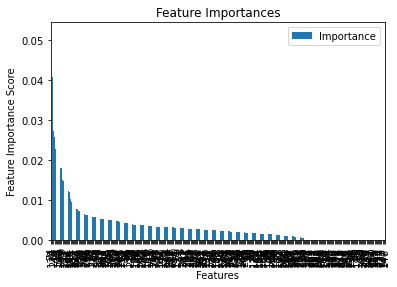

     Features  Importance
74         74    0.051809
120       120    0.040740
12         12    0.027069
210       210    0.025604
15         15    0.022796
..        ...         ...
237       237    0.000000
235       235    0.000000
233       233    0.000000
147       147    0.000000
146       146    0.000000

[293 rows x 2 columns]
[74, 120, 12, 210, 15, 22, 13, 190, 99, 205, 9, 191, 221, 171, 91, 102, 196, 21, 131, 189, 211, 123, 224, 41, 246, 290, 16, 184, 223, 82, 44, 248, 252, 79, 19, 116, 220, 25, 213, 24, 42, 216, 20, 182, 212, 162, 291, 202, 288, 10, 100, 106, 49, 5, 200, 80, 112, 214, 239, 186, 227, 208, 111, 62, 61, 14, 84, 96, 155, 90, 215, 23, 63, 198, 178, 169, 95, 69, 165, 192, 67, 203, 3, 104, 29, 137, 105, 6, 18, 114, 242, 253, 73, 27, 77, 107, 83, 144, 225, 128, 81, 121, 4, 232, 292, 175, 188, 287, 0, 141, 177, 135, 2, 71, 8, 167, 281, 17, 51, 284, 201, 173, 32, 286, 7, 289, 26, 231, 160, 276, 199, 103, 261, 218, 271, 65, 138, 277, 11, 170, 158, 55, 226, 85, 195, 181,

In [37]:
feature_importance = xgb.feature_importances_
features = train_x.columns.tolist()
features_df = pd.DataFrame({'Features': features, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)
features_df.plot('Features', 'Importance', kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print(features_df)
print(features_df["Features"].tolist())

# **CATBOOST MODEL**

In [38]:
from catboost import Pool, CatBoostClassifier, cv

In [39]:
cat = CatBoostClassifier()

print('Training')
cat.fit(train_x,train_y, eval_set = (val_x, val_y))




Training
Learning rate set to 0.139193
0:	learn: 0.4808148	test: 0.4779662	best: 0.4779662 (0)	total: 248ms	remaining: 4m 7s
1:	learn: 0.3577991	test: 0.3564709	best: 0.3564709 (1)	total: 410ms	remaining: 3m 24s
2:	learn: 0.2725457	test: 0.2717452	best: 0.2717452 (2)	total: 624ms	remaining: 3m 27s
3:	learn: 0.2198200	test: 0.2210681	best: 0.2210681 (3)	total: 864ms	remaining: 3m 35s
4:	learn: 0.1832263	test: 0.1846884	best: 0.1846884 (4)	total: 1.06s	remaining: 3m 31s
5:	learn: 0.1621649	test: 0.1643328	best: 0.1643328 (5)	total: 1.26s	remaining: 3m 29s
6:	learn: 0.1477458	test: 0.1497561	best: 0.1497561 (6)	total: 1.49s	remaining: 3m 31s
7:	learn: 0.1360686	test: 0.1384853	best: 0.1384853 (7)	total: 1.71s	remaining: 3m 32s
8:	learn: 0.1284090	test: 0.1312649	best: 0.1312649 (8)	total: 1.89s	remaining: 3m 28s
9:	learn: 0.1231290	test: 0.1263073	best: 0.1263073 (9)	total: 2.17s	remaining: 3m 35s
10:	learn: 0.1189507	test: 0.1231109	best: 0.1231109 (10)	total: 2.5s	remaining: 3m 45s
11:	

In [40]:
print("Predictions")
predictions_2 = cat.predict(val_x)
pred_proba_2 = cat.predict_proba(val_x)[:, 1]



Predictions



Result
Accuracy : 0.9738
AUC : 0.892083
F1 Score : 0.498995


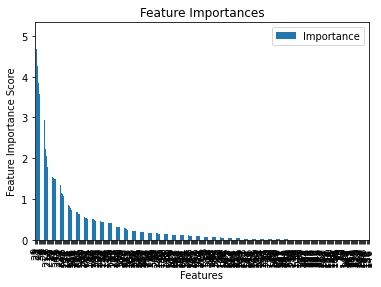

     Features  Importance
9           9    5.083980
21         21    4.686059
3           3    4.255508
22         22    3.845707
2           2    3.587059
..        ...         ...
185       185    0.000000
172       172    0.000000
151       151    0.000000
150       150    0.000000
146       146    0.000000

[293 rows x 2 columns]
[9, 21, 3, 22, 2, 98, 0, 4, 7, 24, 6, 212, 211, 10, 29, 13, 1, 23, 5, 201, 12, 220, 19, 224, 26, 14, 221, 196, 182, 173, 120, 16, 131, 239, 205, 198, 242, 17, 171, 46, 20, 288, 169, 192, 291, 27, 74, 112, 191, 83, 18, 200, 15, 190, 73, 225, 292, 77, 132, 82, 289, 125, 116, 91, 28, 25, 58, 111, 213, 202, 121, 11, 48, 90, 96, 184, 226, 203, 216, 67, 115, 276, 167, 287, 106, 208, 156, 42, 153, 258, 215, 110, 49, 197, 266, 277, 160, 232, 290, 210, 170, 85, 44, 61, 99, 87, 286, 204, 128, 65, 199, 72, 80, 123, 195, 55, 36, 271, 88, 119, 105, 103, 227, 248, 186, 284, 162, 154, 107, 41, 71, 159, 246, 177, 166, 86, 252, 175, 109, 163, 76, 253, 108, 104, 179, 254, 8

In [41]:
print("\nResult")
print("Accuracy : %.4g" % metrics.accuracy_score(val_y, predictions_2))
print("AUC : %f" % metrics.roc_auc_score(val_y, pred_proba_2))
print("F1 Score : %f" % metrics.f1_score(val_y, predictions_2))

    
feature_importance_2 = cat.feature_importances_
features_2 = train_x.columns.tolist()
features_df_2 = pd.DataFrame({'Features': features_2, 'Importance': feature_importance_2}).sort_values(by='Importance', ascending=False)
features_df_2.plot('Features', 'Importance', kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print(features_df_2)
print(features_df_2["Features"].tolist())

As we see in the results for xgboost and catboost models, these models have almost the same accuracy, auc and f1 scores. However, xgboost model is faster than catboost model.

# **Hyperparameter Optimization**

**Random Search for catboost model**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

parameters = {'depth'         : sp_randInt(1, 20),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 80)}
    
random_search_1 = RandomizedSearchCV(estimator = cat, 
                                   param_distributions = parameters,
                                   cv = 5, n_iter = 10, n_jobs=-1)
random_search_1.fit(train_x,train_y, eval_set = (val_x, val_y))

In [ ]:
random_search_1.best_estimator_

In [ ]:
random_search_1.best_params_

In [ ]:
print("Start")
predictions_3 = random_search_1.best_estimator_.predict(val_x)
pred_proba_3 = random_search_1.best_estimator_.predict_proba(val_x)[:, 1]

print("\nResult")
print("Accuracy : %.4g" % metrics.accuracy_score(val_y, predictions_3))
print("AUC : %f" % metrics.roc_auc_score(val_y, pred_proba_3))
print("F1 Score : %f" % metrics.f1_score(val_y, predictions_3))

**Random Search for xgboost model**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

parameters = {'depth'         : sp_randInt(1, 20),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(10, 80)}
    
random_search_2 = RandomizedSearchCV(estimator = xgb, 
                                   param_distributions = parameters,
                                   cv = 5, n_iter = 10, n_jobs=-1)
random_search_2.fit(train_x,train_y, eval_set = (val_x, val_y))

In [ ]:
random_search_2.best_estimator_

In [ ]:
random_search_2.best_params_

In [ ]:
print("Start")
predictions_4 = random_search_2.best_estimator_.predict(val_x)
pred_proba_4 = random_search_2.best_estimator_.predict_proba(val_x)[:, 1]

print("\nResult")
print("Accuracy : %.4g" % metrics.accuracy_score(val_y, predictions_4))
print("AUC : %f" % metrics.roc_auc_score(val_y, pred_proba_4))
print("F1 Score : %f" % metrics.f1_score(val_y, predictions_4))

**Prepare test_transaction data to predict data by using best model. These steps will be similar to data preperation for train_transaction. We will only apply these steps for test_transaction. However, we have to be careful about dropping features because in the test_transaction, if there is no more than half nan values for the features, they will not be dropped but in train_transaction_part, this feature may be dropped. So, we should use the same features.**

# **preprocess for test_transaction**

In [3]:
test_transaction = pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")

In [4]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
test_transaction.shape

(506691, 393)

In [20]:
test_data = test_transaction[train_data.columns]

In [21]:
test_data.shape

(506691, 219)

In [22]:
test_data_1 = test_data.fillna(test_data.median())

In [23]:
test_data_1.isnull().sum(axis = 0)

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
                 ..
V317              0
V318              0
V319              0
V320              0
V321              0
Length: 219, dtype: int64

In [24]:
test_data_1.isnull().sum(axis = 1)

0         1
1         0
2         0
3         1
4         1
         ..
506686    4
506687    4
506688    0
506689    0
506690    4
Length: 506691, dtype: int64

In [25]:
categorical_columns_test = [test_data_1.select_dtypes(include=['object'])]

In [ ]:
test_data_2 = test_data_1.fillna(test_data_1.select_dtypes(include=['object']).mode(), axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
test_x = StandardScaler().fit_transform(test_data_1)
test_x = pd.DataFrame(test_x)
#our test data is ready.
#we can predict its labels by using best model with best parameters.